In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Introduction

## 1.1 Business Problem

A gaming company seeks to develop level-based personas using certain characteristics of its customers. The objective is to create segments based on these new customer profiles and estimate the potential average contribution of prospective customers to the company within these segments.

## 1.2 Dataset Story
The dataset encompasses the pricing information of products offered by an international gaming company, along with demographic details of users making these purchases. The dataset is compiled from records of individual sales transactions. Consequently, the table has not been deduped; in other words, a user with specific demographic traits may have engaged in multiple transactions.

## 1.3 Features
- `PRICE` - The amount of money spent by the customer.
- `SOURCE` - The type of device used by the customer.
- `SEX` - The gender of the customer.
- `COUNTRY` - The country of the customer.
- `AGE` - The age of the customer.

# 2. Data Handling

## 2.1 Loading Data

In [2]:
# Load the dataset
personas = pd.read_csv('personas.csv')

In [3]:
# Display the first few rows
personas.head()

,PRICE,SOURCE,SEX,COUNTRY,AGE
0,39,android,male,bra,17
1,39,android,male,bra,17
2,49,android,male,bra,17
3,29,android,male,tur,17
4,49,android,male,tur,17


## 2.2 Inspecting Data

In [4]:
# Display basic statistics about the dataset
personas.describe()

,PRICE,AGE
count,5000.000000,5000.000000
mean,34.132000,23.581400
std,12.464897,8.995908
min,9.000000,15.000000
25%,29.000000,17.000000
50%,39.000000,21.000000
75%,39.000000,27.000000
max,59.000000,66.000000


In [5]:
# Display information about the dataset
personas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   PRICE    5000 non-null   int64 
 1   SOURCE   5000 non-null   object
 2   SEX      5000 non-null   object
 3   COUNTRY  5000 non-null   object
 4   AGE      5000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 234.4+ KB


In [6]:
# Identify columns with null values
personas.isnull().any()

PRICE      False
SOURCE     False
SEX        False
COUNTRY    False
AGE        False
dtype: bool

In [7]:
# Get the number of unique values in each column
personas.nunique()

PRICE       6
SOURCE      2
SEX         2
COUNTRY     6
AGE        46
dtype: int64

## 2.3 Data Cleaning and Preprocessing

In [8]:
# Define age bins and labels for grouping ages
age_bins = [0, 18, 30, 40, 50, 65, float('inf')]
age_labels = ['0-17', '18-29', '30-39', '40-49', '50-64', '65+']

# Create age groups using bins and labels
personas['AGE_GROUP'] = pd.cut(personas['AGE'], bins=age_bins, labels=age_labels, right=False)

# Group personas by AGE_GROUP and calculate PRICE statistics
personas.groupby('AGE_GROUP')['PRICE'].agg(['sum', 'min', 'max', 'mean']).sort_values(by='mean', ascending=False)

,sum,min,max,mean
AGE_GROUP,,,,
40-49,8895,9,59,34.882353
50-64,3577,19,59,34.728155
0-17,52187,9,59,34.492399
18-29,84356,9,59,33.959742
30-39,21180,9,59,33.619048
65+,465,9,59,31.000000


In [9]:
# Create customer levels based on COUNTRY, SOURCE, SEX and AGE_GROUP
personas['LEVEL'] = [
    f"{persona['COUNTRY'].upper()}_{persona['SOURCE'].upper()}_{persona['SEX'].upper()}_{persona['AGE_GROUP'].upper()}"
    for idx, persona in personas.iterrows()]

# Group personas by LEVEL and calculate PRICE statistics
personas.groupby('LEVEL')['PRICE'].agg(['sum', 'min', 'max', 'mean']).sort_values(by='mean', ascending=False)

,sum,min,max,mean
LEVEL,,,,
DEU_ANDROID_FEMALE_50-64,98,49,49,49.000000
USA_ANDROID_FEMALE_50-64,137,39,49,45.666667
TUR_IOS_MALE_30-39,127,29,49,42.333333
TUR_ANDROID_FEMALE_30-39,459,29,49,41.727273
CAN_ANDROID_MALE_30-39,322,19,49,40.250000
...,...,...,...,...
BRA_ANDROID_MALE_50-64,116,19,39,29.000000
TUR_ANDROID_MALE_30-39,58,19,39,29.000000
CAN_IOS_MALE_30-39,116,29,29,29.000000


In [10]:
# Create customer segments based on LEVEL
personas['SEGMENT'] = pd.qcut(personas['PRICE'], 5, labels=['E', 'D', 'C', 'B', 'A'])

# Group personas by SEGMENT and calculate PRICE statistics
personas.groupby('SEGMENT')['PRICE'].agg(['sum', 'min', 'max', 'mean']).sort_values(by='mean', ascending=False)

,sum,min,max,mean
SEGMENT,,,,
A,12508,59,59,59.000000
B,50519,49,49,49.000000
C,49140,39,39,39.000000
D,37845,29,29,29.000000
E,20648,9,19,17.322148


In [11]:
def categorize_columns(df, cat_th=10, high_card_th=20):
    """
    Categorizes columns in a DataFrame based on specified thresholds.

    Parameters:
    - df: DataFrame
    - cat_thresh: Threshold for considering a column as categorical (default is 10)
    - high_card_thresh: Threshold for considering a categorical column as having high cardinality (default is 20)

    Returns:
    - cat_cols: List of categorical columns
    - num_cols: List of numerical columns
    - high_card_cat_cols: List of categorical columns with high cardinality
    """

    # Identify categorical columns with high cardinality
    high_card_cols = [col for col in df.columns if
                      df[col].dtype in ["category", "object"] and df[col].nunique() > high_card_th]

    # Identify numerical columns that are treated as categorical
    num_but_cat_cols = [col for col in df.columns if
                        df[col].dtype in ["float64", "int64"] and df[col].nunique() < cat_th]

    # Identify categorical columns
    cat_cols = [col for col in df.columns if
                (df[col].dtype in ["category", "object", "bool"] and col not in high_card_cols) or
                (col in num_but_cat_cols)]

    # Identify numerical columns
    num_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and col not in cat_cols]

    # Print dataset overview
    print(f"Dataset Overview:")
    print(f" - Total Columns: {df.shape[1]}")
    print(f" - Numerical Columns: {len(num_cols)}")
    print(f" - Numerical Columns Treated as Categorical: {len(num_but_cat_cols)}")
    print(f" - Categorical Columns: {len(cat_cols)}")
    print(f" - Columns with High Cardinality: {len(high_card_cols)}")

    return cat_cols, num_cols, high_card_cols


# Categorize columns of the dataset
cat_cols, num_cols, high_card_cols = categorize_columns(personas)

Dataset Overview:
 - Total Columns: 8
 - Numerical Columns: 1
 - Numerical Columns Treated as Categorical: 1
 - Categorical Columns: 6
 - Columns with High Cardinality: 1


# 3. Data Visualization

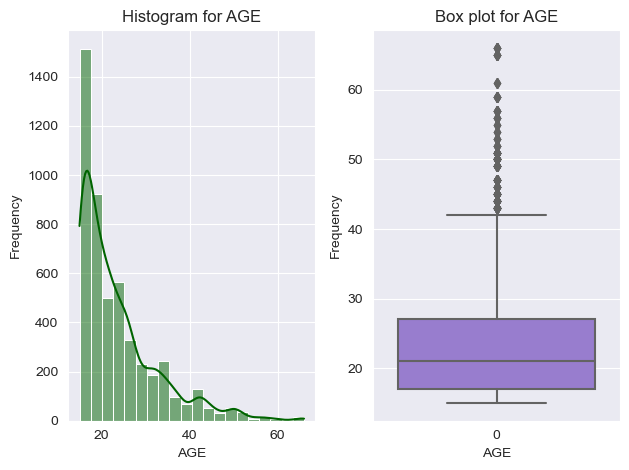

15    569
16    494
17    450
18    348
19    309
20    264
21    257
22    242
26    216
23    210
25    180
24    173
31    120
27    113
28    109
33     95
35     87
37     70
32     68
42     66
29     63
34     61
30     57
38     42
43     36
50     33
44     29
41     28
36     25
45     24
51     23
40     21
47     20
49     19
46     12
57      8
65      8
59      8
56      7
66      7
52      7
53      6
39      5
54      4
55      4
61      3
Name: AGE, dtype: int64


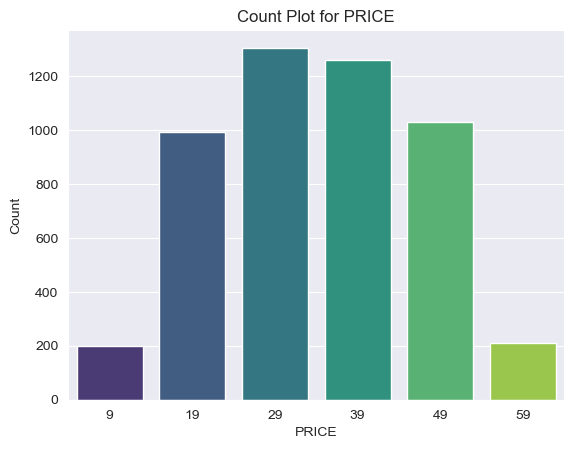

29    1305
39    1260
49    1031
19     992
59     212
9      200
Name: PRICE, dtype: int64


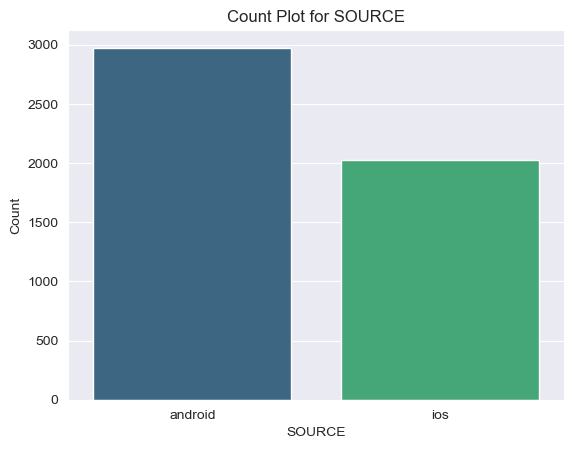

android    2974
ios        2026
Name: SOURCE, dtype: int64


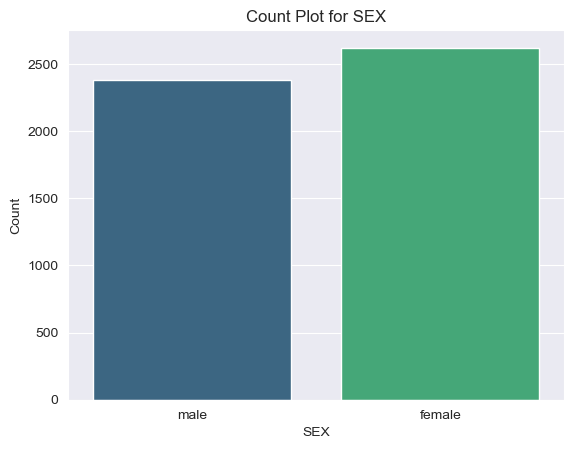

female    2621
male      2379
Name: SEX, dtype: int64


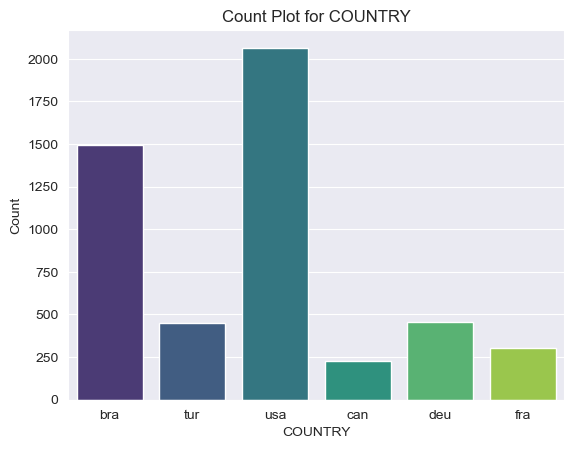

usa    2065
bra    1496
deu     455
tur     451
fra     303
can     230
Name: COUNTRY, dtype: int64


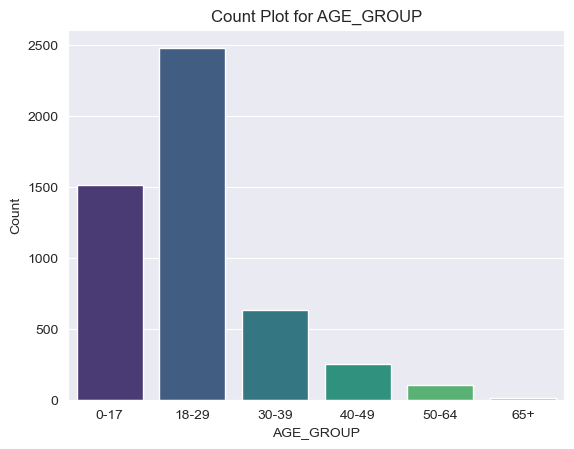

18-29    2484
0-17     1513
30-39     630
40-49     255
50-64     103
65+        15
Name: AGE_GROUP, dtype: int64


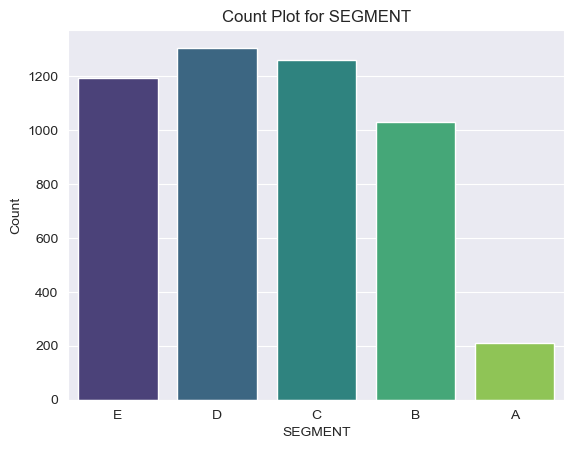

D    1305
C    1260
E    1192
B    1031
A     212
Name: SEGMENT, dtype: int64


In [12]:
def summary_plots(df, num_cols=None, cat_cols=None):
    """
    Generate summary plots for numerical and categorical columns in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - num_cols (list, optional): List of numerical column names. Defaults to None.
    - cat_cols (list, optional): List of categorical column names. Defaults to None.
    """

    # Plot histograms and box plots for numerical columns
    if num_cols is not None:
        for col in num_cols:
            # Create subplots for histograms and boxplots
            fig, axes = plt.subplots(1, 2)

            # Histogram
            sns.histplot(df[col], bins=20, kde=True, color='darkgreen', ax=axes[0])
            axes[0].set_title(f'Histogram for {col}')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('Frequency')

            # Box plot
            sns.boxplot(df[col], color='mediumpurple', ax=axes[1])
            axes[1].set_title(f'Box plot for {col}')
            axes[1].set_xlabel(col)
            axes[1].set_ylabel('Frequency')

            # Adjust layout
            plt.tight_layout()

            # Show the plots
            plt.show()

            # Display the counts of unique values in the column
            print(df[col].value_counts())

    # Plot count plots for categorical columns
    if cat_cols is not None:
        for col in cat_cols:
            sns.countplot(x=col, data=df, palette='viridis')
            plt.title(f'Count Plot for {col}')
            plt.xlabel(col)
            plt.ylabel('Count')

            # Show the plots
            plt.show()

            # Display the counts of unique values in the column
            print(df[col].value_counts())


# Generate summary plots for numerical and categorical columns
summary_plots(personas, num_cols, cat_cols)

# 4. Data Analysis

In [13]:
# Generate information about a randomly sampled persona
for _ in range(5):
    persona = personas.sample()
    print(
        f"- A {persona['AGE'].values[0]}-year-old {'man' if persona['SEX'].values[0] == 'male' else 'woman'} from {persona['COUNTRY'].values[0].upper()} using {'iOS' if persona['SOURCE'].values[0] == 'ios' else 'Android'} belongs to {persona['SEGMENT'].values[0]} segment and spends ${round(np.mean(personas[personas['LEVEL'] == persona['LEVEL'].iloc[0]]['PRICE']), 2)} on average")

- A 24-year-old woman from USA using Android belongs to C segment and spends $32.8 on average
- A 16-year-old man from USA using Android belongs to C segment and spends $34.53 on average
- A 15-year-old man from USA using iOS belongs to E segment and spends $33.85 on average
- A 15-year-old man from USA using Android belongs to B segment and spends $34.53 on average
- A 21-year-old man from BRA using iOS belongs to D segment and spends $33.77 on average
